### Simple Example for Fitting a Generalized Linear Model (GLM) - Hidden Markov Model (HMM) 

This notebook is designed to help users get started using the glmhmm package to fit GLM-HMMs to their data. In this notebook, we fit the GLM-HMM to simulated data and check that we are inferring the correct model parameters. It follows the same procedure as in the HMM fitting notebook, with the only changes being those necessary for fitting a GLM-HMM. 

To see an illustration of how we apply the model to real experimental data (as in [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1)) and create the figures from that paper, check out the <code>fit-glm-hmm-real-data.ipynb</code> notebook.

#### 1. Import the required code packages and modules.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import KFold

path = '../glmhmm/'
sys.path.insert(0, path)

import glm_hmm
from utils import permute_states, find_best_fit, compare_top_weights
from visualize import plot_model_params, plot_loglikelihoods, plot_weights

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = '1'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# set plot design features
font = {'family'   : 'DejaVu Sans',
        'sans-serif' : 'Helvetica',
        'weight'   : 'regular',
        'size'     : 14}

mpl.rc('font', **font)

#### 2. Set the hyper-parameters of the GLM-HMM

In [25]:
N = 10000 # number of data/time points
K = 2 # number of latent states
C = 2 # number of observation classes
D = 6 # number of GLM inputs (regressors)

#### 3. Instantiate the model and generate true parameters

The parameters of a GLM-HMM include the transition probabilities $A$, the GLM weights $w$, and the initial state probabilities $\pi$. The distribution class of the observations can be either "Bernoulli", meaning the observations $y$ take on values of 0 or 1, or "multinomial", meaning the observations can take on integer values from 0 to $C$ (specified above), i.e. $y \in \{0,...,C\}$.

In [28]:
true_GLMHMM = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli")
A_true,w_true,pi_true = true_GLMHMM.generate_params(weights=['uniform',-1,1,1])

#### 4. Given the true parameters, generate some data. 

The data include the observations $y$, the inputs $x$, and the latent states $z$ at each time point. 

In [29]:
true_y,true_z,true_x = true_GLMHMM.generate_data(A_true,w_true)
print(true_y.shape, true_z.shape, true_x.shape)

(10000,) (10000,) (10000, 6)


#### 5. Fit the model

The fitting code uses the expectation maximization (EM) algorithm to infer the model parameters. Because EM does not guarantee that it will find the best fit (global optimum) and inference is often dependent on the choice of parameter initialization, it is often best to fit the model multiple times using different initializations and then select the best one based on which fit obtained the highest log-likelihood. <b>Note:</b> For this example, we are not inferring the initial state probabilities, but instead assuming a uniform distribution over the initial states. See the deterministic annealing HMM notebook for an example where we also infer the initial state probabilities.

In [9]:
inits = 2 # set the number of initializations

# store values for each initialization
lls_all = np.zeros((inits,250))
A_all = np.zeros((inits,K,K))
w_all = np.zeros((inits,K,D,C))

# fit the model for each initialization
for i in range(inits):
    A_init,w_init,pi_init = true_GLMHMM.generate_params() # initialize the model parameters
    lls_all[i,:],A_all[i,:,:],w_all[i,:,:],pi0 = true_GLMHMM.fit(true_y,true_x,A_init,w_init) # fit the model
    print(pi0)
    print('initialization %s complete' %(i+1))

None
initialization 1 complete
None
initialization 2 complete


In [11]:
pi0

Text(0.5, 1.0, 'obs class 2')

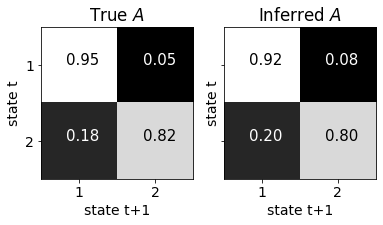

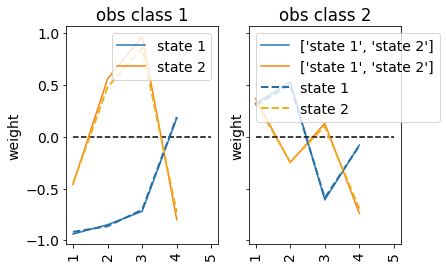

In [10]:
bestix = find_best_fit(lls_all) # find the initialization that led to the best fit

# for easy comparison permute the states in order from highest to lowest self-transition probability
A_permuted, order = permute_states(A_all[bestix])
A_true_permuted, order_true = permute_states(A_true)

# plot the true vs. inferred transition probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
plot_model_params(A_true_permuted,ax[0])
plot_model_params(A_permuted, ax[1])

ax[0].set_title('True $A$')
ax[1].set_title('Inferred $A$')

# permute the observation probability matrices according to the above order
w_permuted,_ = permute_states(w_all[bestix],method='order',param='weights',order=order)
w_true_permuted,_ = permute_states(w_true,method='order',param='weights',order=order_true)

# plot the true vs. inferred observation probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
colors = np.array([[39,110,167],[237,177,32]])/255
for c in range(0,C-1):
    plot_weights(w_true_permuted[:,:,c+1],ax[c],xlabels=['1','2','3','4','5'],label=['state 1','state 2'])
    plot_weights(w_permuted[:,:,c+1], ax[c],color=colors,style='--',label=['state 1','state 2'])

ax[0].legend(['state 1','state 2'])
ax[0].set_title('obs class 1')
ax[1].set_title('obs class 2')


#### 7. Cross validation can further assess model performance.

We can also compare the true vs inferred log-likelihood to see how close we came to the global optimum in our fitting procedure. The best way to do this is to use cross validation, where we split the data into training and test sets and compare the log-likelihoods of the test data. To be rigorous, we should use <i>multi-fold</i> cross-validation, where we split the data into multiple (non-overlapping) train and test sets, fit the model to each of the train sets, evaluate the log-likelihood on each of the test sets, and then take the average. 

In [30]:
# split the data into five folds
folds = 5
train_size = int(N - N/folds)
test_size = int(N/folds)
y_train = [None] * folds
y_test = [None] * folds
x_train = [None] * folds
x_test = [None] * folds
kf = KFold(n_splits=folds)
kf.get_n_splits(true_y)
for i, (train_index, test_index) in enumerate(kf.split(true_y)):
    y_train[i], y_test[i] = true_y[train_index], true_y[test_index]
    x_train[i], x_test[i] = true_x[train_index], true_x[test_index]

In [31]:
inits = 2 # set the number of initializations
true_GLMHMM.n = train_size # reset the number of data points in accordance with the size of the training set
# store values for each initialization
lls_all = []  # List to store log-likelihoods
A_all = []    # List to store A matrices
w_all = []    # List to store w matrices

# fit the model for each training set and each initialization
for i in range(folds):
    fold_lls = []
    fold_As = []
    fold_ws = []
    for j in range(inits):
        A_init, w_init, pi_init = true_GLMHMM.generate_params()  # initialize the model parameters
        print(y_train[i].shape, x_train[i].shape, A_init.shape, w_init.shape)
        lls, A, w, pi0 = true_GLMHMM.fit(y_train[i], x_train[i], A_init, w_init)  # fit the model
        
        # Append results for this initialization
        fold_lls.append(lls)
        fold_As.append(A)
        fold_ws.append(w)
        print(f'Initialization {j+1} complete')

    # Append results for this fold
    lls_all.append(fold_lls)
    A_all.append(fold_As)
    w_all.append(fold_ws)
    print('fold %s complete' %(i+1))

(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 1 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 2 complete
fold 1 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 1 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 2 complete
fold 2 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 1 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 2 complete
fold 3 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 1 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 2 complete
fold 4 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 1 complete
(8000,) (8000, 6) (2, 2) (2, 6, 2)
Initialization 2 complete
fold 5 complete


In [32]:
A_all[0]


[array([[0.69306865, 0.30693135],
        [0.00514919, 0.99485081]]),
 array([[4.89492722e-02, 9.51050728e-01],
        [7.75693933e-04, 9.99224306e-01]])]

In [33]:
# No need to predefine arrays with fixed size
true_ll = []
fit_ll = []

# Evaluate log-likelihood on each test set
for i in range(folds):  # Assuming folds is the actual number of folds used, not hard-coded to 5
    true_GLMHMM.n = len(y_test[i])  # Adjusting to the actual test set size for the current fold

    # Convert true weights into observation probabilities for each state
    phi_true = np.array([true_GLMHMM.glm.compObs(x_test[i], w_true[k]) for k in range(K)])
    phi_true = phi_true.transpose(1, 0, 2)

    # Find the initialization that led to the best fit
    lls = np.array(lls_all[i])  # Convert list of log-likelihoods for current fold to numpy array for processing
    bestix = np.argmax(lls.mean(axis=1))  # Assuming mean log-likelihood is the criterion for best fit

    # Convert inferred weights into observation probabilities for each state
    phi = np.array([true_GLMHMM.glm.compObs(x_test[i], w_all[i][bestix][k]) for k in range(K)])
    phi = phi.transpose(1, 0, 2)

    # Compute true and inferred log-likelihoods
    # print(y_test[i].shape, A_true.shape, phi_true.shape)
    true_log_likelihood,_,_,_ = true_GLMHMM.forwardPass(y_test[i], A_true, phi_true, pi0=None)
    fit_log_likelihood,_,_,_ = true_GLMHMM.forwardPass(y_test[i], A_all[i][bestix], phi)

    true_ll.append(true_log_likelihood)
    fit_ll.append(fit_log_likelihood)

# Print results
print('True LL: %f' % np.mean(true_ll))
print('Inferred LL: %f' % np.mean(fit_ll))

True LL: -367.063096
Inferred LL: -407.955466
